# Machine Learning and Predictive Analytics
### Final Project - Machine Generated Abstract Art
#### Group 1:
- Amro Shanshal
- Yue Wu
- Rose Ro
- Arpit Parihar

****

#### Model 2 - Base GAN
****

### Setup

**Importing Libraries**

In [1]:
from os import makedirs, listdir
from PIL import Image
import numpy as np
from numpy import zeros, ones
from numpy.random import randn, randint
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.initializers import RandomNormal
from matplotlib import pyplot
import joblib
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Mounting Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Model Architecture

**Defining the discriminator**

In [3]:
def define_discriminator(in_shape=(64, 64, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, padding="same", kernel_initializer=init, input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model


**Defining the generator**

In [4]:
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding = "same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding = "same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding = "same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding = "same", kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, kernel_size=3, padding = "same", activation='tanh', kernel_initializer=init))

    return model


**Combining Generator and Discriminator models to update the generator**

In [5]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


### Data Import and Training Loop

**Function to load data**

In [6]:
def load_real_samples():
    X = []
    data_path = '/content/gdrive/Shareddrives/Machine Learning Final Project - GANs/GAN Training Data/Abstract_gallery_64/'

    imagesList = listdir(data_path)
    for image in imagesList:
        img = np.asarray(Image.open(data_path + image))
        X.append(img)
    
    X = np.array(X)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    
    return X


**Function to sample real images**

In [7]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y


**Function to generate points in latent space, or "noise" as input to the generator**

In [8]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


**Function to use the generator to generate n fake examples, with class labels**

In [9]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

**Generate samples and save as a plot**

In [10]:
def summarize_performance(step, g_model, latent_dim, bat_per_epo, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        pyplot.grid(b=None)
        # plot raw pixel data
        pyplot.imshow(X[i])
    # save plot to file
    pyplot.savefig('results_baseline/images/generated_plot_%04d.png' % (reload_epoch + (step // bat_per_epo) + 1))
    pyplot.close()


**Create a line plot of loss for the GAN and save to file**

In [11]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.close()


**Train the generator and discriminator**

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, reload_epoch, n_epochs=10, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        if not i % bat_per_epo:
          print('\n' + '\033[1m' + '\033[4m' + f'EPOCH {reload_epoch + (i // bat_per_epo) + 1}' + '\033[0m')
        print('Step %d/%d ====> d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
              (((i % bat_per_epo) + 1), bat_per_epo, d_loss1, d_loss2, g_loss, int(100 * d_acc1), int(100 * d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i + 1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim, bat_per_epo)
            d_model.save('results_baseline/models/d_model_%04d.h5' % (reload_epoch + (i // bat_per_epo) + 1))
            g_model.save('results_baseline/models/g_model_%04d.h5' % (reload_epoch + (i // bat_per_epo) + 1))
            gan_model.save('results_baseline/models/gan_model_%04d.h5' % (reload_epoch + (i // bat_per_epo) + 1))

    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)



**Calling the functions to train the model**

In [13]:
%cd '/content/gdrive/Shareddrives/Machine Learning Final Project - GANs/Base GAN/'
data_path = '/content/gdrive/Shareddrives/Machine Learning Final Project - GANs/GAN Training Data/Abstract_gallery_64/'
reload_epoch = 259

# make folder for results
makedirs('results_baseline', exist_ok=True)
makedirs('results_baseline/models', exist_ok=True)
makedirs('results_baseline/images', exist_ok=True)
# size of the latent space
latent_dim = 50

# create the discriminator
try:
  discriminator = load_model('results_baseline/models/d_model_%04d.h5' % reload_epoch)
  print(f'Loaded discriminator model from epoch {reload_epoch}')
except:
  discriminator = define_discriminator()

# create the generator
try:
  generator = load_model('results_baseline/models/g_model_%04d.h5' % reload_epoch)
  print(f'Loaded generator model from epoch {reload_epoch}')

except:
  generator = define_generator(latent_dim)

# create the gan
try:
  gan_model = load_model('results_baseline/models/gan_model_%04d.h5' % reload_epoch)
  print(f'Loaded gan model from epoch {reload_epoch}')

except:
  gan_model = define_gan(generator, discriminator)

# load image data
try:
  dataset = joblib.load(data_path + 'Abstract64.yue')
except:
  dataset = load_real_samples()
  joblib.dump(dataset, data_path + 'Abstract64.yue')

print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, reload_epoch, n_epochs=1000, n_batch=64)

/content/gdrive/Shareddrives/Machine Learning Final Project - GANs/Base GAN
Loaded discriminator model from epoch 259
Loaded generator model from epoch 259
Loaded gan model from epoch 259
(2782, 64, 64, 3)


### Model Results

**Generating images**

In [21]:
r, c = (20, 20)
dim = 64

images, _ = generate_fake_samples(generator, latent_dim, r * c)
images = (images + 1) / 2.0
images = [Image.fromarray(x) for x in np.uint8(images*255)]

**Plotting images**

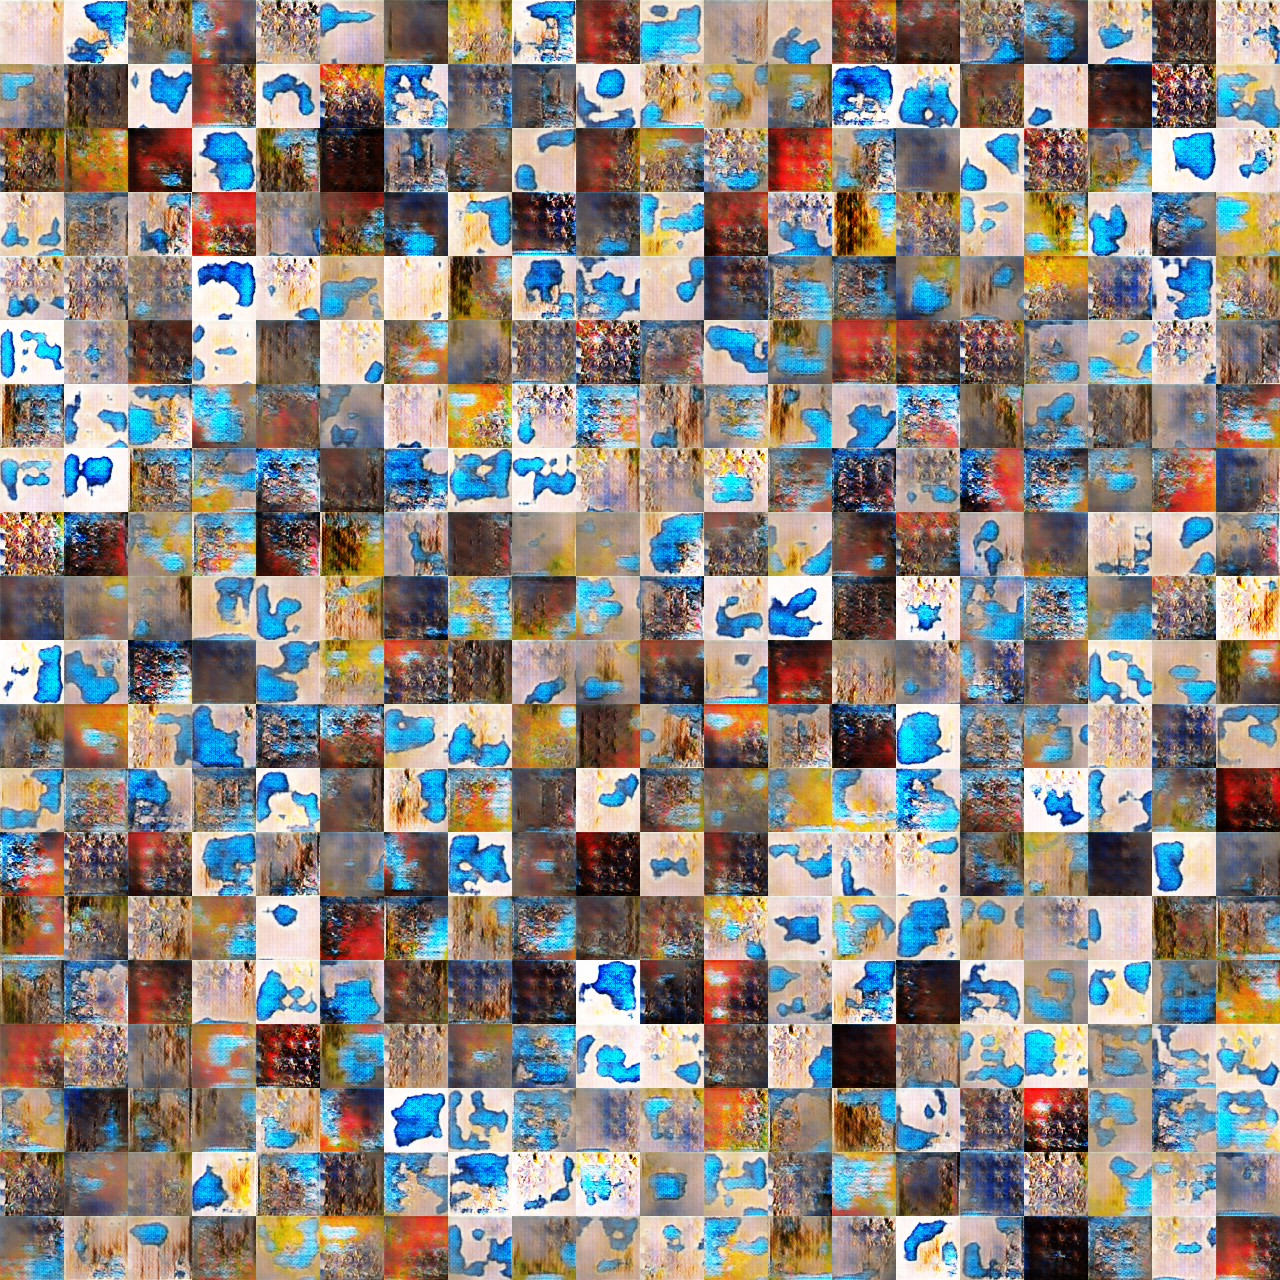

In [22]:
new_im = Image.new('RGB', (dim * r, dim * c))

for i, im in enumerate(images):
  new_im.paste(im, (dim * (i % r), dim * (i // c)))
new_im